In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
from dark_emulator_public import dark_emulator
import os, sys, time, json, copy
import matplotlib.pyplot as plt
from collections import OrderedDict as od
from scipy.interpolate import InterpolatedUnivariateSpline as ius
from scipy.interpolate import interp2d, interp1d
from scipy.integrate import simps
from tqdm import tqdm
import hsc3x2pt

using dark_emulator at  /lustre/work/sunao.sugiyama/package/dark_emulator_public/dark_emulator/__init__.py


In [3]:
power_b1 = hsc3x2pt.power_b1_class()

initialize cosmo_class
Initialize pklin emulator
initialize propagator emulator
Initialize sigma_d emulator
initialize cross-correlation emulator
initialize auto-correlation emulator
Initialize sigmaM emulator
initialize xinl emulator


# Year 1, single source bin analysis

In [11]:
%%time
dirname = './single_source_ClY1'
fisher2x2pt = hsc3x2pt.getFisher(dirname, power_b1, probes=['w', 'gamma_t'], 
                                 label='2x2pt (Y1, 1)', Omega_s={'gamma_t':140, 'xi':140})
fisherCS = hsc3x2pt.getFisher(dirname, power_b1, probes=['xi+','xi-'], 
                              label='Cosmic Shear (Y1, 1)', Omega_s={'gamma_t':140, 'xi':140})
fisher3x2pt = hsc3x2pt.getFisher(dirname, power_b1, 
                                 label='3x2pt (Y1, 1)', Omega_s={'gamma_t':140, 'xi':140})

cov.shape = (66, 66), dim(data)=(66,)
cov.shape = (17, 17), dim(data)=(17,)
skip b1lowz because this is lens galaxy param, while probes does not include any lens related probe.
skip b1cmass1 because this is lens galaxy param, while probes does not include any lens related probe.
skip b1cmass2 because this is lens galaxy param, while probes does not include any lens related probe.
skip alphamaglowz because this is lens galaxy param, while probes does not include any lens related probe.
skip alphamagcmass1 because this is lens galaxy param, while probes does not include any lens related probe.
skip alphamagcmass2 because this is lens galaxy param, while probes does not include any lens related probe.
cov.shape = (83, 83), dim(data)=(83,)
CPU times: user 7.22 s, sys: 4.55 s, total: 11.8 s
Wall time: 12.3 s


In [5]:
fisher2x2ptPrior = fisher2x2pt.addPrior([0.00038, 0.0042, 0.5, 0.5, 0.5, 0.1, 0.01], 
                                        ['omega_b', 'ns', 
                                         'alphamaglowz','alphamagcmass1','alphamagcmass2',
                                         'dzph','dm'], label='Prior')

fisher3x2ptPrior = fisher3x2pt.addPrior([0.00038, 0.0042, 0.5, 0.5, 0.5, 0.1, 0.01], 
                                        ['omega_b', 'ns', 
                                         'alphamaglowz','alphamagcmass1','alphamagcmass2',
                                         'dzph','dm'], label='Prior')

fisherCSPrior = fisherCS.addPrior([0.00038, 0.0042, 0.1, 0.01], 
                                  ['omega_b', 'ns', 
                                   'dzph','dm'], label='Prior')

In [6]:
hsc3x2pt.compare1Sigma([fisherCS, fisherCSPrior, fisher2x2pt, fisher2x2ptPrior, fisher3x2pt, fisher3x2ptPrior], 
                       ['Omega_de', 'sigma8', 'b1lowz', 'dm', 'dzph'])

,$\Omega_\mathrm{de}$,$\sigma_8$,"$b_\mathrm{1,LOWZ}$",$\Delta m$,$\Delta z_\mathrm{ph}$
"Cosmic Shear (Y1, 1)",10.65898,7.57310,-1.00000,7.69874,10.39433
"Cosmic Shear (Y1, 1) + Prior",0.14402,0.16718,-1.00000,0.01000,0.09967
"2x2pt (Y1, 1)",0.01047,0.09833,0.39210,0.59877,1.13562
"2x2pt (Y1, 1) + Prior",0.00715,0.05710,0.12476,0.00998,0.08594
"3x2pt (Y1, 1)",0.00871,0.07942,0.30679,0.34282,0.38757
"3x2pt (Y1, 1) + Prior",0.00701,0.02550,0.06103,0.00997,0.06968


In [12]:
corner = hsc3x2pt.corner_class()

b1lowz is not included any fisher analysis. Omitting it.


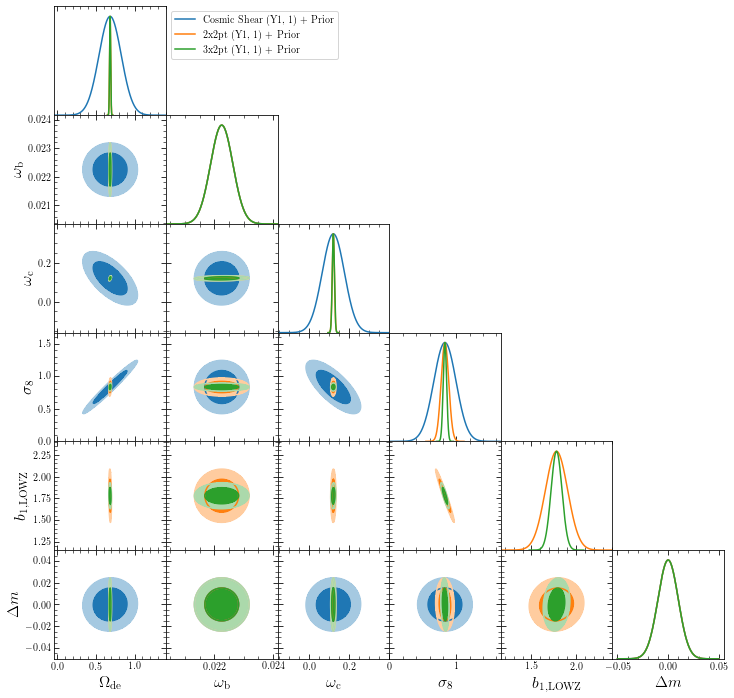

In [30]:
fig = corner.plot_corner([fisherCSPrior, fisher2x2ptPrior, fisher3x2ptPrior], 
                         ['Omega_de', 'omega_b', 'omega_c', 'sigma8', 'b1lowz', 'dm'], 
                         figsize_ratio=2, usetex=True)
fig.export('figures/corner_f2x2ptY1singlePrior_fCSY1singlePrior_f3x2ptY1singlePrior.pdf')

In [31]:
chainReader = hsc3x2pt.chain_reader_class()
samplesHSCY12x2ptRealData = chainReader.getHSCY12x2ptSugiyama()

Removed no burn in


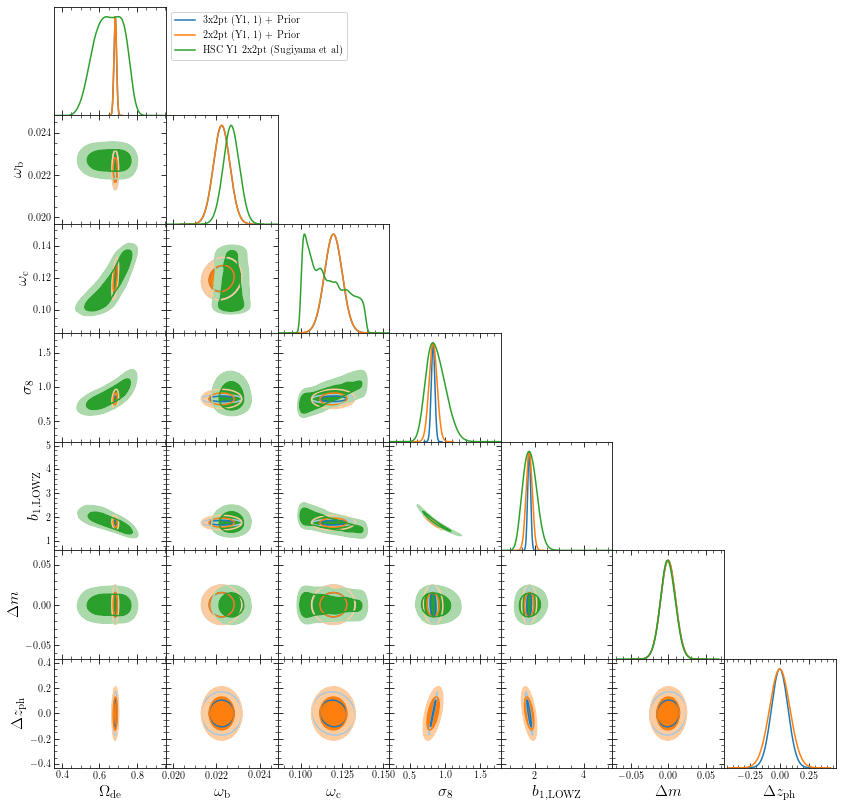

In [34]:
fig = corner.plot_corner([fisher3x2ptPrior, fisher2x2ptPrior, samplesHSCY12x2ptRealData], 
                         ['Omega_de', 'omega_b', 'omega_c', 'sigma8', 'b1lowz', 'dm', 'dzph'], 
                         figsize_ratio=2, usetex=True)
fig.export('figures/corner_f3x2ptY1singlePrior_f2x2ptY1singlePrior_real2x2ptY1.pdf')

# Year 1, double source bin analysis

In [15]:
%%time
dirname = './double_source_ClY1'
fisher2x2pt2 = hsc3x2pt.getFisher(dirname, power_b1, probes=['w', 'gamma_t'], 
                                  label='2x2pt (Y1, 2)', Omega_s={'gamma_t':140, 'xi':140})
fisherCS2 = hsc3x2pt.getFisher(dirname, power_b1, probes=['xi+','xi-'], 
                               label='Cosmic Shear (Y1, 2)', Omega_s={'gamma_t':140, 'xi':140})
fisher3x2pt2 = hsc3x2pt.getFisher(dirname, power_b1, 
                                  label='3x2pt (Y1, 2)', Omega_s={'gamma_t':140, 'xi':140})

cov.shape = (90, 90), dim(data)=(90,)
cov.shape = (51, 51), dim(data)=(51,)
skip b1lowz because this is lens galaxy param, while probes does not include any lens related probe.
skip b1cmass1 because this is lens galaxy param, while probes does not include any lens related probe.
skip b1cmass2 because this is lens galaxy param, while probes does not include any lens related probe.
skip alphamaglowz because this is lens galaxy param, while probes does not include any lens related probe.
skip alphamagcmass1 because this is lens galaxy param, while probes does not include any lens related probe.
skip alphamagcmass2 because this is lens galaxy param, while probes does not include any lens related probe.
cov.shape = (141, 141), dim(data)=(141,)
CPU times: user 19 s, sys: 3.32 s, total: 22.4 s
Wall time: 22.5 s


In [ ]:
fisher2x2ptPrior = fisher2x2pt2.addPrior([0.00038, 0.0042, 0.5, 0.5, 0.5, 0.1, 0.1, 0.01], 
                                        ['omega_b', 'ns', 
                                         'alphamaglowz','alphamagcmass1','alphamagcmass2',
                                         'dzph1','dzph2','dm'], label='Prior')

fisher3x2ptPrior = fisher3x2pt2.addPrior([0.00038, 0.0042, 0.5, 0.5, 0.5, 0.1, 0.1, 0.01], 
                                        ['omega_b', 'ns', 
                                         'alphamaglowz','alphamagcmass1','alphamagcmass2',
                                         'dzph1','dzph2','dm'], label='Prior')

In [16]:
hsc3x2pt.compare1Sigma([fisherCS2, fisher2x2pt2, fisher2x2ptPrior2, fisher3x2pt2, fisher3x2ptPrior2], 
                       ['Omega_de', 'sigma8', 'b1lowz', 'dm', 'dzph'])

omega_b         -- 0.03137707647914588
omega_c         -- 0.07110188598533909
Omega_de        -- 0.010412388870321932
sigma8          -- 0.09816521338607632
ns              -- 0.17530897193715672
b1lowz          -- 0.38732804471806326
b1cmass1        -- 0.2399297310448155
b1cmass2        -- 0.24818025205725144
alphamaglowz    -- 103.37075591690981
alphamagcmass1  -- 21.414448347094392
alphamagcmass2  -- 20.714984884357847
dzph1           -- 0.8076221393271756
dzph2           -- 1.4485703875219367
dm              -- 0.5738651208258745


In [17]:
fisherCS2.show1Sigma()

omega_b   -- 0.5183559969967207
omega_c   -- 1.2702539461861222
Omega_de  -- 1.638971625262438
sigma8    -- 0.647806547402774
ns        -- 1.2898211739336138
dzph1     -- 0.739589444757695
dzph2     -- 1.0657444806809802
dm        -- 3.009272135066728


In [18]:
fisher3x2pt2.show1Sigma()

omega_b         -- 0.029805009788196495
omega_c         -- 0.06312659937324266
Omega_de        -- 0.008233824334558687
sigma8          -- 0.06944212342942221
ns              -- 0.10803722224240479
b1lowz          -- 0.2579732756483804
b1cmass1        -- 0.21374191307100351
b1cmass2        -- 0.22928271367454617
alphamaglowz    -- 50.1373721146029
alphamagcmass1  -- 5.8830689520865596
alphamagcmass2  -- 3.2204053320033466
dzph1           -- 0.13330235341656826
dzph2           -- 0.18821061322817115
dm              -- 0.18003028071319777


In [28]:
corner = hsc3x2pt.corner_class()

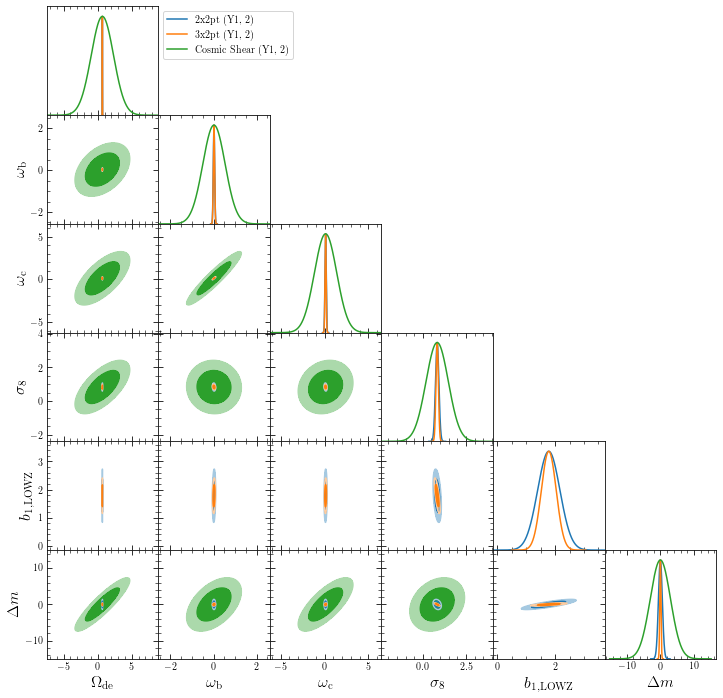

In [21]:
fig = corner.plot_corner([fisher2x2pt2, fisher3x2pt2, fisherCS2], 
                         ['Omega_de', 'omega_b', 'omega_c', 'sigma8', 'b1lowz', 'dm'], 
                         figsize_ratio=2, usetex=True)
fig.export('figures/corner_f2x2ptY1_f3x2ptY1_fCSY1_double.pdf')

## double vs single source anlaysis

dzph1 is not included any fisher analysis. Omitting it.


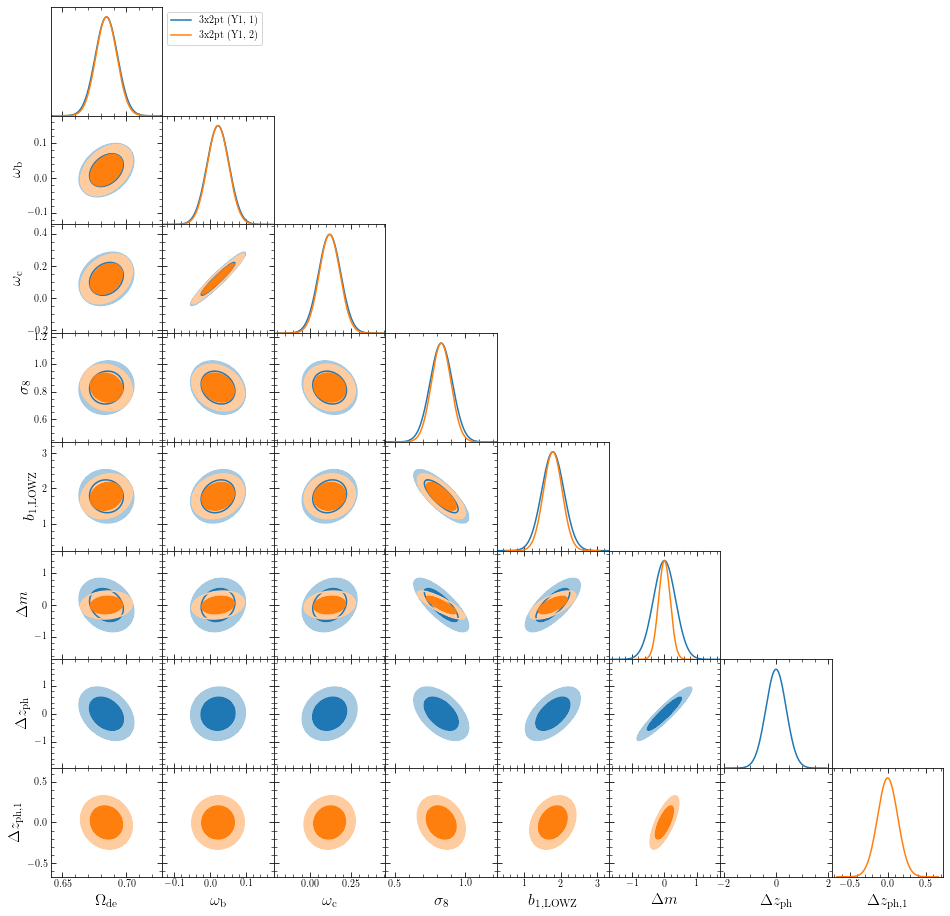

In [22]:
fig = corner.plot_corner([fisher3x2pt, fisher3x2pt2], 
                         ['Omega_de', 'omega_b', 'omega_c', 'sigma8', 'b1lowz', 'dm', 'dzph', 'dzph1'], 
                         figsize_ratio=2, usetex=True)
fig.export('figures/corner_f3x2ptY1_single_double.pdf')

# Cosmic Shear alone: tomography with quadruple sources

In [23]:
%%time
dirname = './quadruple_source_ClY1'
fisherCSquad = hsc3x2pt.getFisher(dirname, power_b1, 
                                  label='CS (quad)', Omega_s={'gamma_t':140, 'xi':140})

cov.shape = (170, 170), dim(data)=(170,)
CPU times: user 33.5 s, sys: 12.8 s, total: 46.3 s
Wall time: 47.1 s


In [24]:
corner = hsc3x2pt.corner_class()

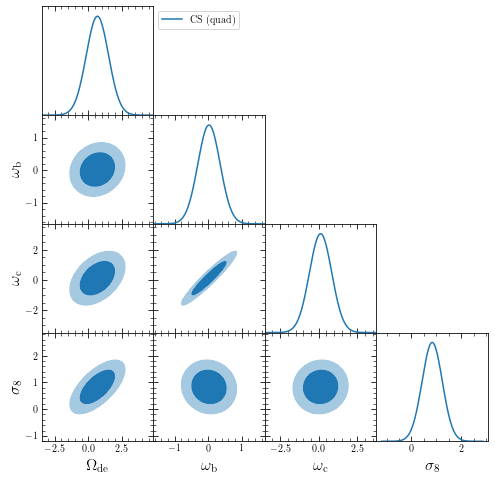

In [25]:
fig = corner.plot_corner([fisherCSquad], 
                         ['Omega_de', 'omega_b', 'omega_c', 'sigma8'],
                         figsize_ratio=2, usetex=True)
fig.export('figures/corner_fCSY1quad.pdf')

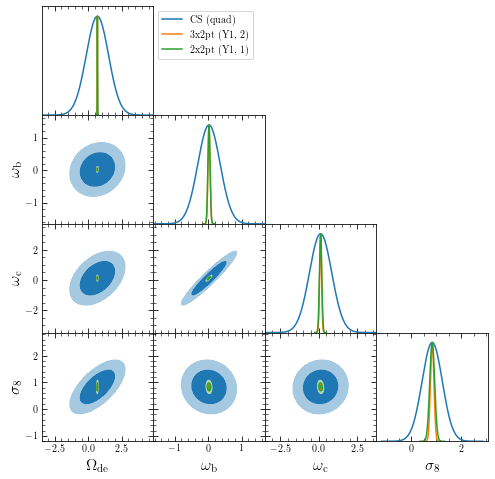

In [26]:
fig = corner.plot_corner([fisherCSquad, fisher3x2pt2, fisher2x2pt], 
                         ['Omega_de', 'omega_b', 'omega_c', 'sigma8'], 
                         figsize_ratio=2, usetex=True)
fig.export('figures/corner_fCSY1quad_f3x2ptY1double_f2x2ptY1single.pdf')

# Questions
- HSC Y1 2x2ptのfisherとreal解析で、制限の強さが違う。特にOmega_m。sigma8はそこまで変じゃない。
- multiplicative biasは各source redshift binに振るのではないのか？
- source 4つにすると手前のsource bin redshiftがlens sampleと重なるのでモデリングが大変→やらない、という話だったが、では4 source redshift binをとって手前の2 source samplesはcosmic shear tomographyにのみ使ってg-g lensingに使わない、というのはどうか？(Fisherできる。)

## hot to make joint Fisher

using dark_emulator at  /lustre/work/sunao.sugiyama/package/dark_emulator_public/dark_emulator/__init__.py


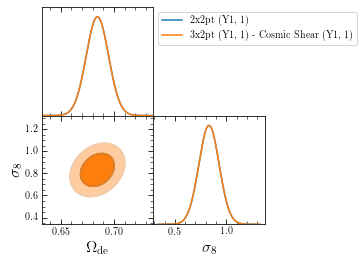

In [48]:
fisherNew = fisher3x2pt - fisherCS

corner.plot_corner([fisher2x2pt, fisherNew], ['Omega_de', 'sigma8'], 
                   figsize_ratio=2, usetex=True)

In [49]:
fisherNew = fisher2x2pt + fisherCS

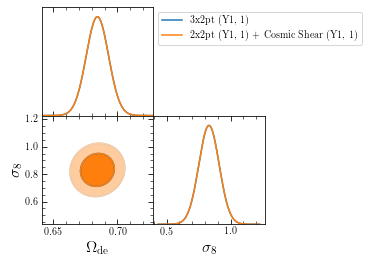

In [50]:
corner.plot_corner([fisher3x2pt, fisherNew], ['Omega_de', 'sigma8'], 
                   figsize_ratio=2, usetex=True)